**STOCK QUANTITY FORECASTING MODEL APPLIED TO OZWIDE TOOLS SALES TRANSACTIONS**
```
Important note:
Python Version: 3.8
Tensorflow Version:  2.6.0
Keras Version:  2.6.0
Numpy Version:  1.19.5 
```



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import os

In [2]:
# import data
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  df = pd.read_csv('/content/drive/MyDrive/Institute_of_Data/Capstone/Data/Stock_Movements.csv', parse_dates=['TransactionDate'], index_col='TransactionDate', infer_datetime_format=True, dayfirst=True, encoding='cp1252')
  df_flyers = pd.read_csv('/content/drive/MyDrive/Institute_of_Data/Capstone/Data/Flyers_Signals.csv', parse_dates=['Date'], index_col='Date', infer_datetime_format=True, dayfirst=True)
  print('Running on CoLab')
else:
  print('Not running on CoLab')
  df = pd.read_csv('Data/Stock_Movements.csv', parse_dates=['TransactionDate'], index_col='TransactionDate', infer_datetime_format=True, dayfirst=True, encoding='cp1252')
  df_flyers = pd.read_csv('Data/Flyers_Signals.csv', parse_dates=['Date'], index_col='Date', infer_datetime_format=True, dayfirst=True)

Mounted at /content/drive
Running on CoLab


In [3]:
df.head()

,StockID,Part,StockDescription,TransactionID,SourceTypeID,SourceType,SourceID,Reference,Detail,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Contact
TransactionDate,,,,,,,,,,,,,,,,
2020-07-31,4283,10I-SERIES,NaN,5070,29,Supplier Invoice,132,OT30016,104,1.0,942.85,942.85,0.0,1.0,27.0,Automotive Test Solutions - ATS
2020-09-15,4283,10I-SERIES,NaN,7726,21,Customer Invoice,4244,OT45431,N046749,-1.0,-942.85,942.85,1450.0,0.0,1498.0,Wittaya Mala
2021-04-12,4581,AIR-CPM-20,"1/4"" Male Swivel Joint",21036,29,Supplier Invoice,1644,OT30175,VTIV0004975,5.0,57.85,11.57,0.0,5.0,198.0,TENG TOOLS
2021-05-25,4615,AIR-CSW-02,Universal Swivel Joint - Block Style,23825,29,Supplier Invoice,1759,OT30205,VITV0005582,2.0,23.74,11.87,0.0,2.0,228.0,TENG TOOLS
2020-07-06,1,AIR-R420FC,"1/4"" Female Coupler R420FC",2513,29,Supplier Invoice,2,OT30001,VTIV0001018,25.0,145.00,5.80,0.0,32.0,1.0,TENG TOOLS


In [4]:
# drop rows with part numbers ending with "-R" in Part Column - These are rental parts which are not in the scope of the project
df = df[df.Part.str.contains('-R') == False]
# drop rows with "FREIGHT" and "NETO FREIGHT" in Part Column - Not needed for this project
df = df[df.Part.str.contains('FREIGHT') == False]
df = df[df.Part.str.contains('NETO FREIGHT') == False]

In [5]:
# information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15592 entries, 2020-07-31 to 2021-06-30
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StockID           15592 non-null  int64  
 1   Part              15592 non-null  object 
 2   StockDescription  15286 non-null  object 
 3   TransactionID     15592 non-null  int64  
 4   SourceTypeID      15592 non-null  int64  
 5   SourceType        15592 non-null  object 
 6   SourceID          15592 non-null  int64  
 7   Reference         15592 non-null  object 
 8   Detail            11896 non-null  object 
 9   Qty               15592 non-null  float64
 10  Cost              15590 non-null  float64
 11  CostEach          15590 non-null  float64
 12  Amount            15592 non-null  float64
 13  New Total Qty     14414 non-null  float64
 14  DocumentID        13934 non-null  float64
 15  Contact           15003 non-null  object 
dtypes: float64(6), int64(4)

In [6]:
# create new dataset subseting df by SourceTypeID 21 and 200  - These two codes are for Qty sold and Qty returned due to credits
df_pur = df.loc[(df['SourceTypeID'] == 21) | (df['SourceTypeID'] == 200)]
df_pur.head()

,StockID,Part,StockDescription,TransactionID,SourceTypeID,SourceType,SourceID,Reference,Detail,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Contact
TransactionDate,,,,,,,,,,,,,,,,
2020-09-15,4283,10I-SERIES,NaN,7726,21,Customer Invoice,4244,OT45431,N046749,-1.0,-942.8500,942.8500,1450.00,0.0,1498.0,Wittaya Mala
2021-07-05,3465,ATE-FB30SR,ATE Brake Bleeding Machine,26760,21,Customer Invoice,22242,OT52362,35S60333,-1.0,-2000.0000,2000.0000,2510.00,0.0,9101.0,Manny
2021-02-05,4279,BOR2000,iC Inspection Camera,15659,21,Customer Invoice,12223,OT48398,N048864,-1.0,-1508.9082,1508.9082,2195.00,1.0,4940.0,Hud Cavka
2021-03-11,4279,BOR2000,iC Inspection Camera,17884,21,Customer Invoice,12998,OT49304,NaN,-1.0,-1508.9082,1508.9082,2195.00,0.0,5264.0,Jason Robinson
2021-10-13,4279,BOR2000,iC Inspection Camera,33400,21,Customer Invoice,28921,OT55171,NaN,-1.0,-1302.7210,1302.7210,2295.45,1.0,12052.0,Leif Coplin


In [7]:
# info about the data
df_pur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11912 entries, 2020-09-15 to 2020-07-28
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   StockID           11912 non-null  int64  
 1   Part              11912 non-null  object 
 2   StockDescription  11780 non-null  object 
 3   TransactionID     11912 non-null  int64  
 4   SourceTypeID      11912 non-null  int64  
 5   SourceType        11912 non-null  object 
 6   SourceID          11912 non-null  int64  
 7   Reference         11912 non-null  object 
 8   Detail            8683 non-null   object 
 9   Qty               11912 non-null  float64
 10  Cost              11912 non-null  float64
 11  CostEach          11912 non-null  float64
 12  Amount            11912 non-null  float64
 13  New Total Qty     11284 non-null  float64
 14  DocumentID        11892 non-null  float64
 15  Contact           11892 non-null  object 
dtypes: float64(6), int64(4)

In [8]:
# resample the data to daily frequency and sum the columns
df_pur_daily = df_pur.resample('D').sum()
df_pur_daily.head()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID
TransactionDate,,,,,,,,,,
2020-07-01,859,2372,200,2371,1.0,11.06,11.06,-47.00,4.0,0.0
2020-07-02,0,0,0,0,0.0,0.00,0.00,0.00,0.0,0.0
2020-07-03,6398,10147,84,382,-4.0,-93.38,93.38,313.18,18.0,158.0
2020-07-04,0,0,0,0,0.0,0.00,0.00,0.00,0.0,0.0
2020-07-05,0,0,0,0,0.0,0.00,0.00,0.00,0.0,0.0


In [9]:
# mulyiply the Qty column by -1 to get the net movement
df_pur_daily['Qty'] = df_pur_daily['Qty'] * -1

In [10]:
# drop last row - las row dropped since it was just the first day of the month
df_pur_daily = df_pur_daily.drop(df_pur_daily.tail(1).index)

In [11]:
# display the first 5 rows of the dataframe
df_pur_daily.head()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID
TransactionDate,,,,,,,,,,
2020-07-01,859,2372,200,2371,-1.0,11.06,11.06,-47.00,4.0,0.0
2020-07-02,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0
2020-07-03,6398,10147,84,382,4.0,-93.38,93.38,313.18,18.0,158.0
2020-07-04,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0
2020-07-05,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0


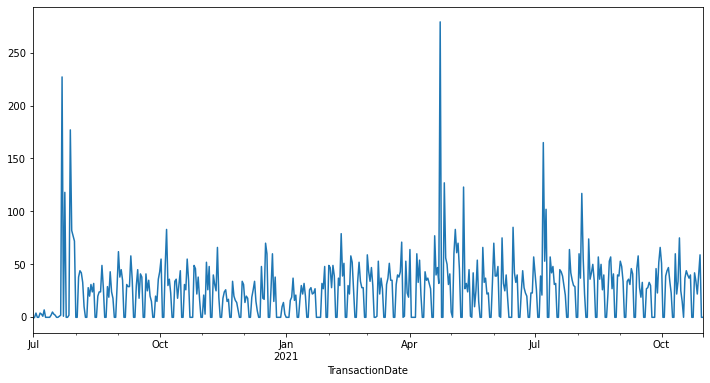

In [12]:
# plot Qty on a daily basis - this is the daily movement of the inventory including weekends and holidays
df_pur_daily['Qty'].plot(figsize=(12, 6))
plt.show()

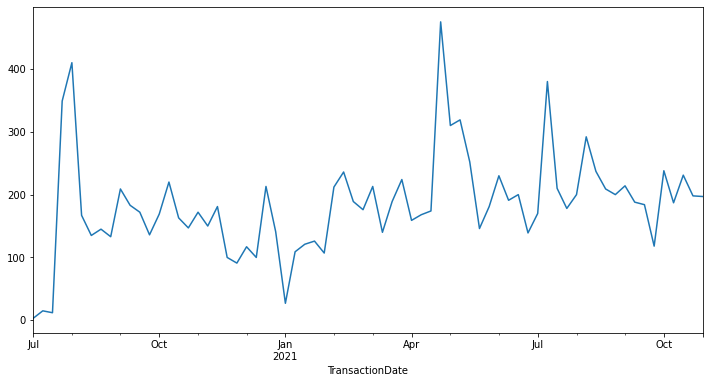

In [13]:
# plot Qty on a weekly basis
df_pur_daily['Qty'].resample('W').sum().plot(figsize=(12, 6))
plt.show()

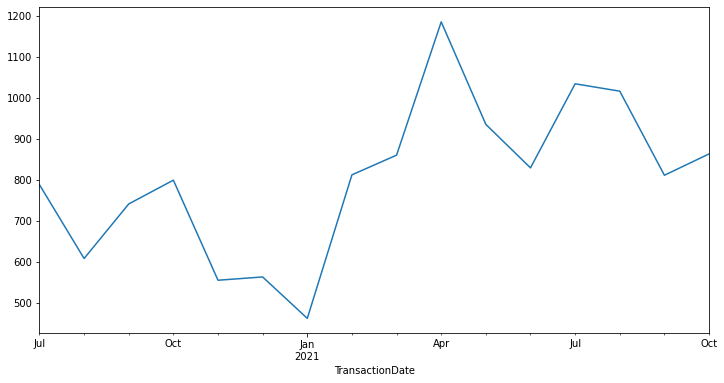

In [14]:
# plot qty on a monthly basis
df_pur_daily['Qty'].resample('M').sum().plot(figsize=(12, 6))
plt.show()

In [15]:
# dataset tail
df_pur_daily.tail()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID
TransactionDate,,,,,,,,,,
2021-10-27,31635,718885,441,625172,22.0,-1939.6887,1933.4684,3357.01,297.0,261196.0
2021-10-28,82061,1270381,956,1108924,40.0,-1139.9846,1247.7051,1718.37,488.0,461557.0
2021-10-29,68559,1584214,1145,1379614,59.0,-1875.0100,1786.7406,2919.00,628.0,574717.0
2021-10-30,0,0,0,0,-0.0,0.0000,0.0000,0.00,0.0,0.0
2021-10-31,0,0,0,0,-0.0,0.0000,0.0000,0.00,0.0,0.0


In [16]:
# Create a new column with month name and year - this is used to group the data by month and plot the data
df_pur_daily['Month'] = df_pur_daily.index.to_period('M')
df_pur_daily.head()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Month
TransactionDate,,,,,,,,,,,
2020-07-01,859,2372,200,2371,-1.0,11.06,11.06,-47.00,4.0,0.0,2020-07
2020-07-02,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0,2020-07
2020-07-03,6398,10147,84,382,4.0,-93.38,93.38,313.18,18.0,158.0,2020-07
2020-07-04,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0,2020-07
2020-07-05,0,0,0,0,-0.0,0.00,0.00,0.00,0.0,0.0,2020-07


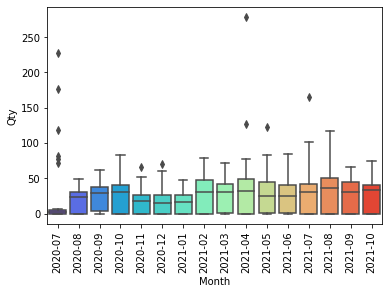

In [17]:
# boxplot of Qty by month seaborn - We can notice here that the zero quantities are skewing the data
sns.boxplot(x='Month', y='Qty', data=df_pur_daily, palette='rainbow')
plt.xticks(rotation=90)
plt.show()

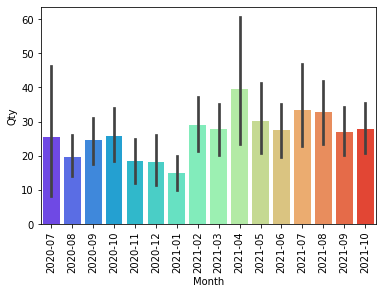

In [18]:
# barplot of Qty by month seaborn
sns.barplot(x='Month', y='Qty', data=df_pur_daily, palette='rainbow')
plt.xticks(rotation=90)
plt.show()

In [19]:
# create new dataframe with data from Aug 2020 to Oct 31 2021 - we decided to drop the first month data since a new system was implemented and the data wasn't consistent
df_pur_daily_2020 = df_pur_daily.loc['2020-08-01':'2021-10-31']
df_pur_daily_2020.head()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Month
TransactionDate,,,,,,,,,,,
2020-08-01,0,0,0,0,-0.0,0.0000,0.0000,0.00,0.0,0.0,2020-08
2020-08-02,0,0,0,0,-0.0,0.0000,0.0000,0.00,0.0,0.0,2020-08
2020-08-03,47250,169277,777,94861,38.0,-1190.1300,1180.9300,3118.16,453.0,31961.0,2020-08
2020-08-04,54858,255501,2208,158236,44.0,-1503.5200,1557.2200,4207.88,489.0,49362.0,2020-08
2020-08-05,61756,210211,1082,116976,42.0,-3333.1057,5478.3357,6449.84,347.0,38749.0,2020-08


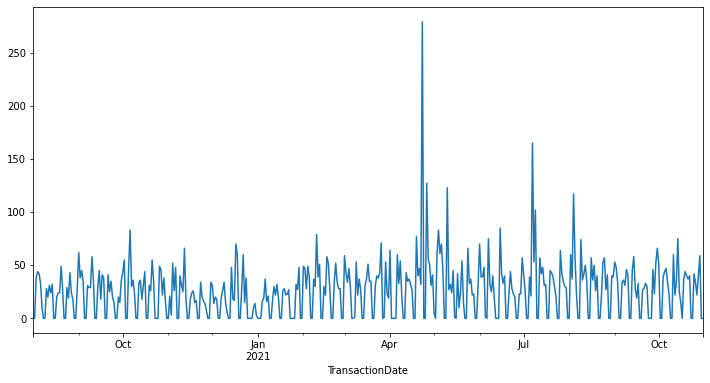

In [20]:
# plot qty on a daily basis - New data from Aug 2020 to Oct 31 2021
df_pur_daily_2020['Qty'].plot(figsize=(12, 6)) 
plt.show()

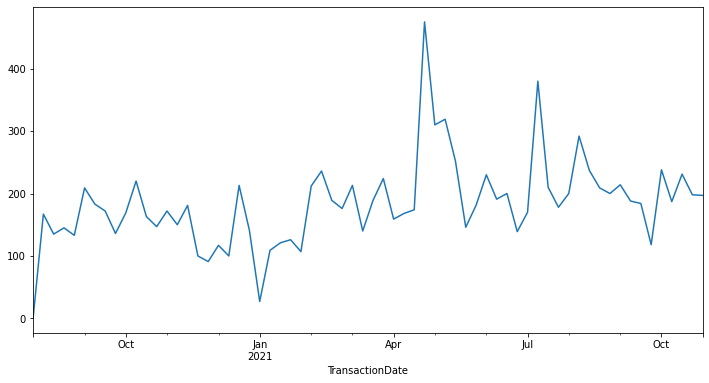

In [21]:
# plot qty on a weekly basis
df_pur_daily_2020['Qty'].resample('W').sum().plot(figsize=(12, 6))
plt.show()

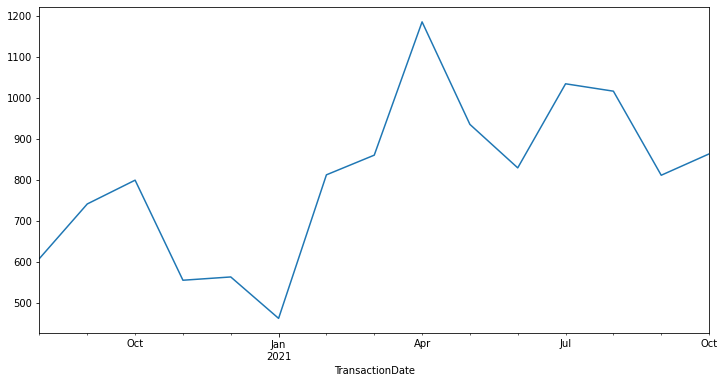

In [22]:
# plot qty on a monthly basis
df_pur_daily_2020['Qty'].resample('M').sum().plot(figsize=(12, 6))
plt.show()

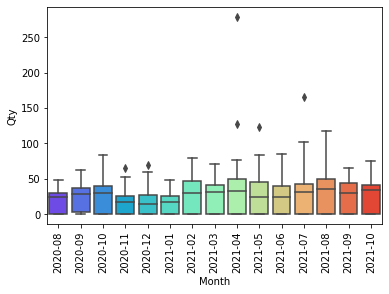

In [23]:
# boxplot of Qty by month seaborn - We ploted again the data with zero quantities to compare
sns.boxplot(x='Month', y='Qty', data=df_pur_daily_2020, palette='rainbow')
plt.xticks(rotation=90)
plt.show()

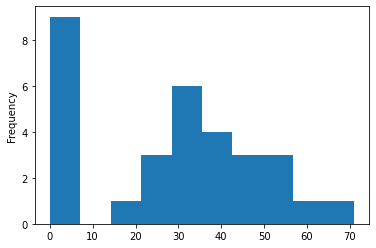

In [24]:
# plot a histogram of Qty for March 2021
df_pur_daily_2020['Qty'].loc['2021-03-01':'2021-03-31'].plot(kind='hist')
plt.show()

In [25]:
# We decided to drop the first month since a new system was implemented and the data was not accurate
# We also decided to drop weekends it will creat a lot of noise
df_pur_daily_2020 = df_pur_daily_2020.drop(df_pur_daily_2020[df_pur_daily_2020['Qty'] == 0].index)

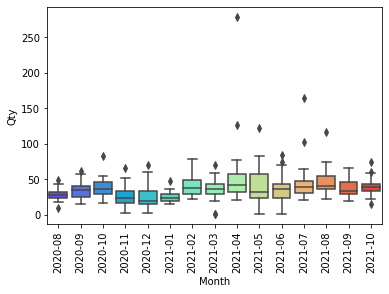

In [26]:
# boxplot of Qty by month zero quantities dropped (Weekends and holidays)
sns.boxplot(x='Month', y='Qty', data=df_pur_daily_2020, palette='rainbow')
plt.xticks(rotation=90)
plt.show()

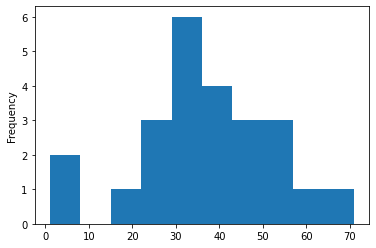

In [27]:
# plot a histogram of Qty for March 2021 with weekends dropped - We can notice that the skewness is reduced
df_pur_daily_2020['Qty'].loc['2021-03-01':'2021-03-31'].plot(kind='hist')
plt.show()

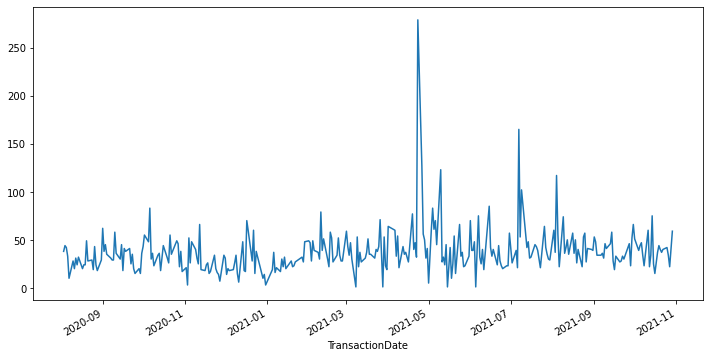

In [28]:
# plot Qty on a daily basis
df_pur_daily_2020['Qty'].plot(figsize=(12, 6))
plt.show()

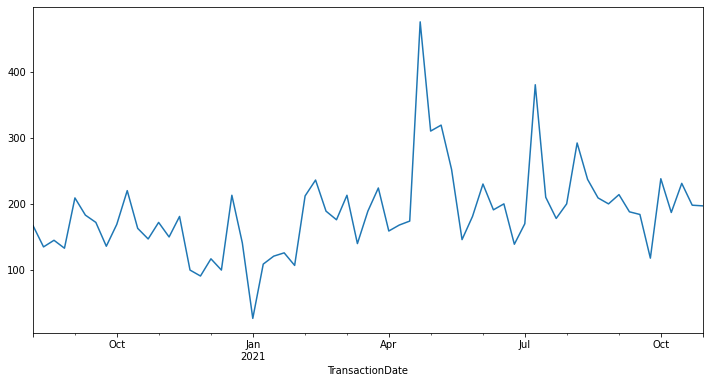

In [29]:
# plot Qty on a weekly basis
df_pur_daily_2020['Qty'].resample('W').sum().plot(figsize=(12, 6))
plt.show()

In [30]:
# import data
# we created a time series with special sales for 2020 and 2021 to input as a signal
df_flyers.head()

,Ozwide Flyer,Hsy Flyer
Date,,
2020-07-01,0,1
2020-07-02,0,1
2020-07-03,0,1
2020-07-04,0,0
2020-07-05,0,0


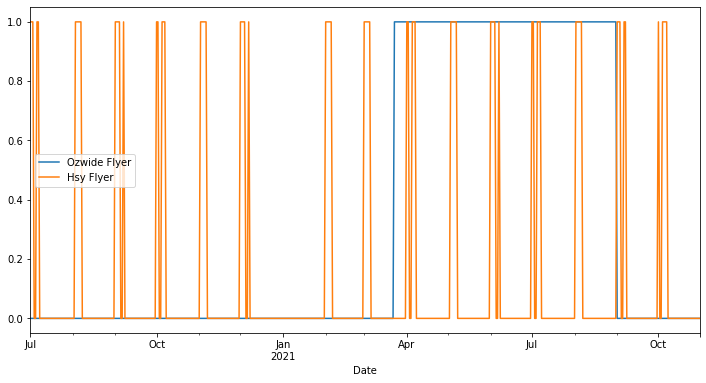

In [31]:
# plot df_flyers
df_flyers.plot(figsize=(12, 6))
plt.show()

In [32]:
# join df_pur_daily_2020 and df_flyers on the index - new dataset including the flyers signal
df_pur_daily_2020_flyers = df_pur_daily_2020.join(df_flyers, how='inner')
df_pur_daily_2020_flyers.head(10)

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Month,Ozwide Flyer,Hsy Flyer
2020-08-03,47250,169277,777,94861,38.0,-1190.1300,1180.9300,3118.16,453.0,31961.0,2020-08,0,1
2020-08-04,54858,255501,2208,158236,44.0,-1503.5200,1557.2200,4207.88,489.0,49362.0,2020-08,0,1
2020-08-05,61756,210211,1082,116976,42.0,-3333.1057,5478.3357,6449.84,347.0,38749.0,2020-08,0,1
2020-08-06,48940,183010,1314,111223,33.0,-1590.1800,1581.9600,4544.90,1323.0,34600.0,2020-08,0,1
2020-08-07,16091,60290,431,37660,10.0,-1116.5300,1756.5300,2184.82,71.0,12145.0,2020-08,0,1
2020-08-10,39879,159346,830,96700,28.0,-920.9050,1063.2850,2476.49,189.0,31293.0,2020-08,0,0
2020-08-11,20926,89053,357,53570,20.0,-761.3500,685.5750,2106.37,138.0,18339.0,2020-08,0,0
2020-08-12,65806,159903,630,95649,31.0,-2124.5900,2124.5900,4251.67,185.0,32886.0,2020-08,0,0
2020-08-13,45564,140864,725,87941,24.0,-1260.6500,1272.1900,3321.48,204.0,29630.0,2020-08,0,0
2020-08-14,39918,175975,672,106988,32.0,-901.9619,901.9619,2472.72,371.0,36958.0,2020-08,0,0


In [33]:
# we created three new columns with the day, week and month of the year to pick up trends based on seasonal patterns
# create column day of the year
df_pur_daily_2020_flyers['DayOfYear'] = df_pur_daily_2020_flyers.index.dayofyear
# create column day of the week
df_pur_daily_2020_flyers['DayOfWeek'] = df_pur_daily_2020_flyers.index.dayofweek
# create column month
df_pur_daily_2020_flyers['Month'] = df_pur_daily_2020_flyers.index.month
df_pur_daily_2020_flyers.head()

,StockID,TransactionID,SourceTypeID,SourceID,Qty,Cost,CostEach,Amount,New Total Qty,DocumentID,Month,Ozwide Flyer,Hsy Flyer,DayOfYear,DayOfWeek
2020-08-03,47250,169277,777,94861,38.0,-1190.1300,1180.9300,3118.16,453.0,31961.0,8,0,1,216,0
2020-08-04,54858,255501,2208,158236,44.0,-1503.5200,1557.2200,4207.88,489.0,49362.0,8,0,1,217,1
2020-08-05,61756,210211,1082,116976,42.0,-3333.1057,5478.3357,6449.84,347.0,38749.0,8,0,1,218,2
2020-08-06,48940,183010,1314,111223,33.0,-1590.1800,1581.9600,4544.90,1323.0,34600.0,8,0,1,219,3
2020-08-07,16091,60290,431,37660,10.0,-1116.5300,1756.5300,2184.82,71.0,12145.0,8,0,1,220,4


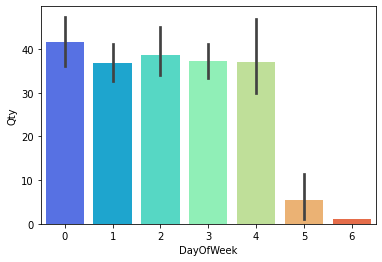

In [34]:
# barplot of Qty by day of the week seaborn
sns.barplot(x='DayOfWeek', y='Qty', data=df_pur_daily_2020_flyers, palette='rainbow')
plt.show()

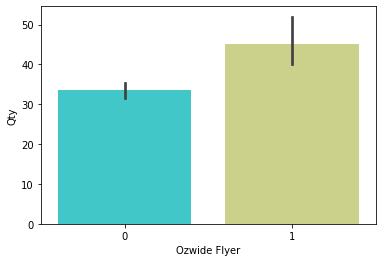

In [35]:
# barplot of Qty by day of the week seaborn
sns.barplot(x='Ozwide Flyer', y='Qty', data=df_pur_daily_2020_flyers, palette='rainbow')
plt.show()

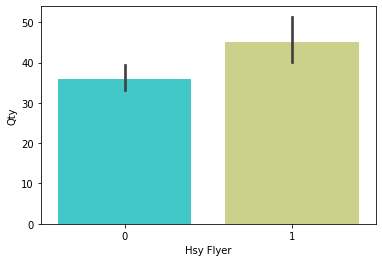

In [36]:
# barplot of Qty by day of the week seaborn
sns.barplot(x='Hsy Flyer', y='Qty', data=df_pur_daily_2020_flyers, palette='rainbow')
plt.show()

In [37]:
# drop columns StockID, TransactionID, SourceTypeID, SourceID, Cost, CostEach, Amount, New Total Qty, DocumentID
# the result of this dataset is our dataframe with the features needed for the model
df_pur_daily_2020_flyers = df_pur_daily_2020_flyers.drop(['StockID', 'TransactionID', 'SourceTypeID', 'SourceID', 'Cost', 'CostEach', 'Amount', 'New Total Qty', 'DocumentID'], axis=1)
df_pur_daily_2020_flyers.head()

,Qty,Month,Ozwide Flyer,Hsy Flyer,DayOfYear,DayOfWeek
2020-08-03,38.0,8,0,1,216,0
2020-08-04,44.0,8,0,1,217,1
2020-08-05,42.0,8,0,1,218,2
2020-08-06,33.0,8,0,1,219,3
2020-08-07,10.0,8,0,1,220,4


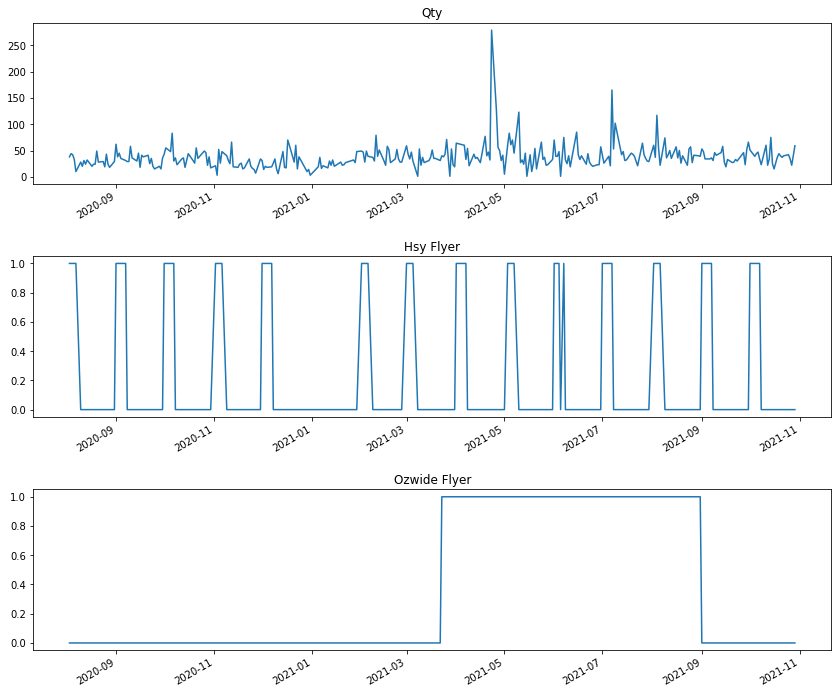

In [38]:
# plot Qty, Hsy Flyer and Ozwide Flyer on a daily basis in different plots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
# add titles to each plot
axs[0].set_title('Qty')
axs[1].set_title('Hsy Flyer')
axs[2].set_title('Ozwide Flyer')
df_pur_daily_2020_flyers['Qty'].plot(ax=axs[0])
df_pur_daily_2020_flyers['Hsy Flyer'].plot(ax=axs[1])
df_pur_daily_2020_flyers['Ozwide Flyer'].plot(ax=axs[2])
fig.tight_layout(pad=2.0)
plt.show()

In [39]:
# target variable
target = ['Qty']
# time steps in the future
shift_moths = 1
shifth_steps = shift_moths * 30
# create a new column with the shifted values - this is the way to predict the future values based on the past values this is the method used to conver this into a supervised learning problem
df_pur_daily_2020_flyers['Qty_shift'] = df_pur_daily_2020_flyers['Qty'].shift(-shifth_steps)
df_pur_daily_2020_flyers.head()

,Qty,Month,Ozwide Flyer,Hsy Flyer,DayOfYear,DayOfWeek,Qty_shift
2020-08-03,38.0,8,0,1,216,0,30.0
2020-08-04,44.0,8,0,1,217,1,45.0
2020-08-05,42.0,8,0,1,218,2,18.0
2020-08-06,33.0,8,0,1,219,3,41.0
2020-08-07,10.0,8,0,1,220,4,38.0


In [40]:
# check the data has been shifted in the future
df_pur_daily_2020_flyers.tail(5)

,Qty,Month,Ozwide Flyer,Hsy Flyer,DayOfYear,DayOfWeek,Qty_shift
2021-10-25,42.0,10,0,0,298,0,NaN
2021-10-26,34.0,10,0,0,299,1,NaN
2021-10-27,22.0,10,0,0,300,2,NaN
2021-10-28,40.0,10,0,0,301,3,NaN
2021-10-29,59.0,10,0,0,302,4,NaN


In [41]:
# generate numpy array of the data
X = df_pur_daily_2020_flyers[['Qty','DayOfYear', 'DayOfWeek', 'Month', 'Hsy Flyer', 'Ozwide Flyer']].values[0:-shifth_steps]
y = df_pur_daily_2020_flyers['Qty_shift'].values[0:-shifth_steps]
print('X shape is:', X.shape)
print('y shape is:', y.shape)

X shape is: (290, 6)
y shape is: (290,)


In [42]:
# import preprocessing and model selection libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print('X_train shape is:', X_train.shape)
print('X_test shape is:', X_test.shape)
print('y_train shape is:', y_train.shape)
print('y_test shape is:', y_test.shape)

X_train shape is: (261, 6)
X_test shape is: (29, 6)
y_train shape is: (261,)
y_test shape is: (29,)


In [44]:
# scale data
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [45]:
# data shape
print('X_train_scaled shape is:', X_train_scaled.shape)
print('X_test_scaled shape is:', X_test_scaled.shape)

X_train_scaled shape is: (261, 6)
X_test_scaled shape is: (29, 6)


In [46]:
print('Min: ', X_train_scaled.min())
print('Max: ', X_train_scaled.max())

Min:  0.0
Max:  1.0


In [47]:
# scale y data
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))
y_train_scaled = y_train_scaled.reshape(-1)
y_test_scaled = y_test_scaled.reshape(-1)

In [48]:
# data shape
print('y_train_scaled shape is:', y_train_scaled.shape)
print('y_test_scaled shape is:', y_test_scaled.shape)

y_train_scaled shape is: (261,)
y_test_scaled shape is: (29,)


In [49]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 6)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X_train.shape[0] - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [50]:
X_batch, y_batch = next(batch_generator(batch_size=300, sequence_length=90))

In [51]:
print(X_batch.shape)
print(y_batch.shape)

(300, 90, 6)
(300, 90)


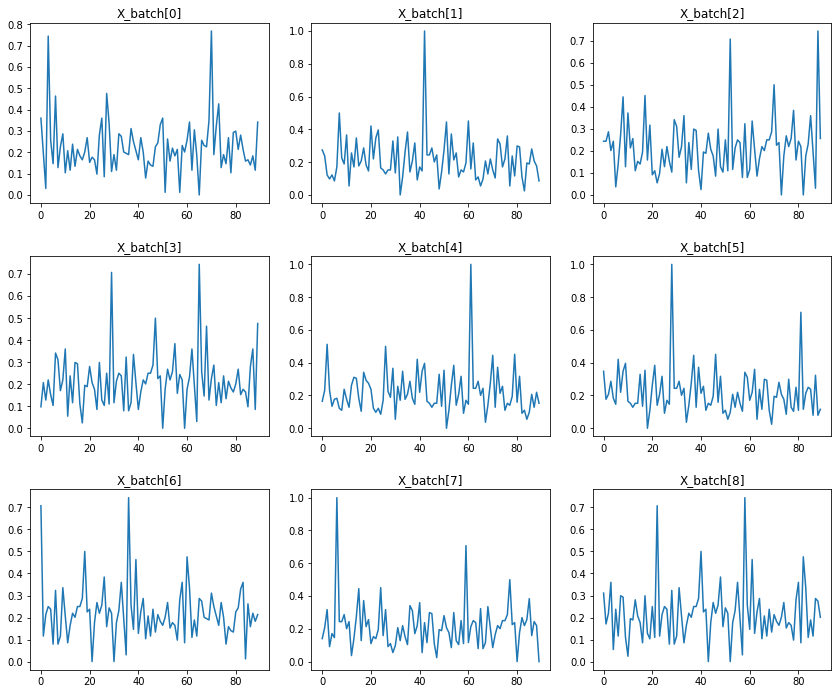

In [52]:
# plot a 3 X 3 plot of X_batch[9 , :, 0]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    axs[i//3, i%3].plot(X_batch[i, :, 0])
    axs[i//3, i%3].set_title('X_batch[{}]'.format(i))
fig.tight_layout(pad=2.0)
plt.show()

In [53]:
validation_data = (X_test_scaled.reshape((1, X_test_scaled.shape[0], X_test_scaled.shape[1])), y_test_scaled.reshape((1, y_test_scaled.shape[0])))

In [54]:
# import RNN libraries tensoflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, SimpleRNN, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed, InputLayer
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print('Tensorflow Version: ',tf.__version__)
print('Keras Version: ',tf.keras.__version__)
print('Numpy Version: ',np.__version__)

Tensorflow Version:  2.6.0
Keras Version:  2.6.0
Numpy Version:  1.19.5


In [55]:
# learning curves function
def plot_learning_curves(loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    # plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [56]:
# plot predictions function
def plot_comparison(start_idx, length=100, train=True, model=None):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = X_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    # x = np.expand_dims(x, axis=0)
    x = x.reshape((1, x.shape[0], x.shape[1]))

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, 5, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()
        # print sklearn mean squared error
        print('MSE:', np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [57]:
# Create the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(None, 6)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(Dense(1, activation='relu'))

In [58]:
%%time
# compile the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_batch, y_batch, epochs=200, validation_data=validation_data, verbose=1, steps_per_epoch=50, callbacks=EarlyStopping(monitor='val_loss', patience=100, verbose=1))

Epoch 1/200
50/50 [==============================] - 7s 95ms/step - loss: 0.0254 - val_loss: 0.0275
Epoch 2/200
50/50 [==============================] - 4s 90ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 3/200
50/50 [==============================] - 5s 91ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 4/200
50/50 [==============================] - 4s 89ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 5/200
50/50 [==============================] - 5s 91ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 6/200
50/50 [==============================] - 4s 90ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 7/200
50/50 [==============================] - 5s 90ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 8/200
50/50 [==============================] - 4s 90ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 9/200
50/50 [==============================] - 5s 91ms/step - loss: 0.0252 - val_loss: 0.0275
Epoch 10/200
50/50 [==============================] - 5s 90ms/step - loss: 0.0252 - val_loss: 0.0275

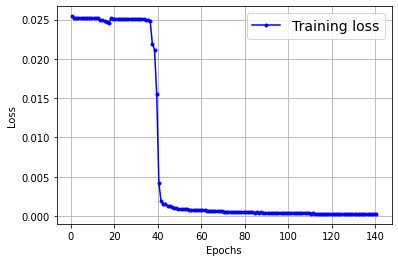

In [59]:
# plot learning curves
plot_learning_curves(history.history['loss'])
plt.show()

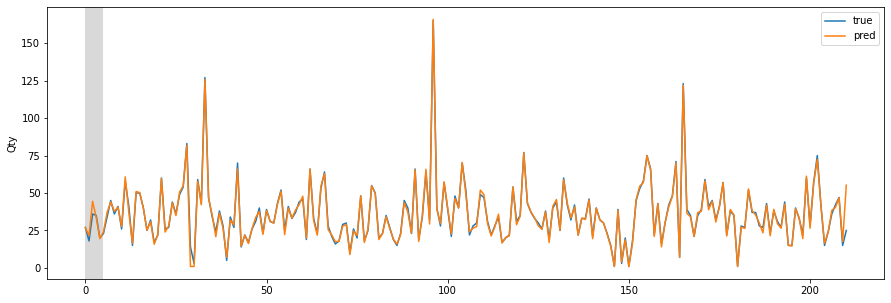

MSE: 2.7125771947364585


In [60]:
# plot predictions train
plot_comparison(start_idx=50, length=250, train=True, model=model)

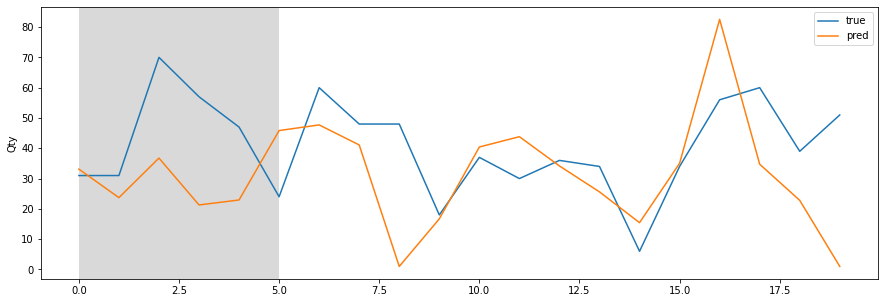

MSE: 22.775383570437466


In [61]:
# plot predictions test
plot_comparison(start_idx=0, length=20, train=False, model=model)

In [62]:
# create LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, return_sequences=True, input_shape=(None, 6)))
model_LSTM.add(LSTM(50, return_sequences=True))
model_LSTM.add(Dense(1, activation='relu'))

In [63]:
%%time
# compile the model
model_LSTM.compile(optimizer='adam', loss='mse')
history_LSTM = model_LSTM.fit(X_batch, y_batch, epochs=200, validation_data=validation_data, verbose=1, steps_per_epoch=100, callbacks=EarlyStopping(monitor='val_loss', patience=50, verbose=1))

Epoch 1/200
100/100 [==============================] - 5s 14ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 2/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 3/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 4/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 5/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0060 - val_loss: 0.0096
Epoch 6/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0055 - val_loss: 0.0100
Epoch 7/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0049 - val_loss: 0.0140
Epoch 8/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0204
Epoch 9/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0227
Epoch 10/200
100/100 [==============================] - 1s 7ms/step - loss: 0.0030 - val_l

In [64]:
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 50)          11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


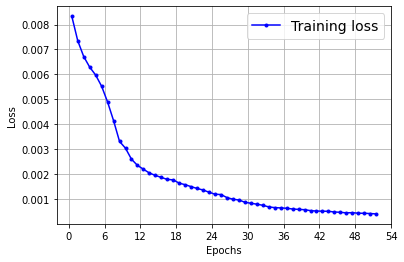

In [65]:
# plot learning curves
plot_learning_curves(history_LSTM.history['loss'])
plt.show()

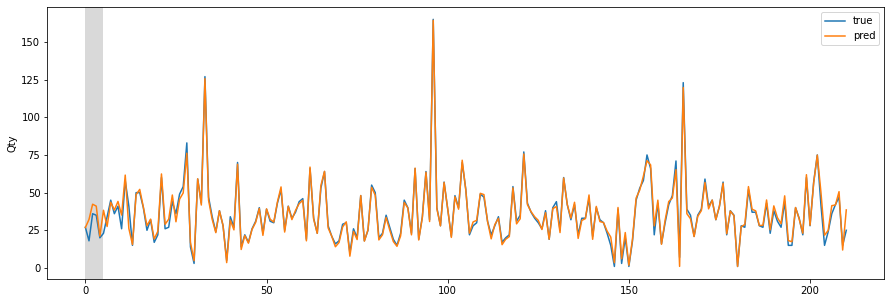

MSE: 3.042882207915885


In [66]:
# plot predictions train
plot_comparison(start_idx=50, length=250, train=True, model=model_LSTM)

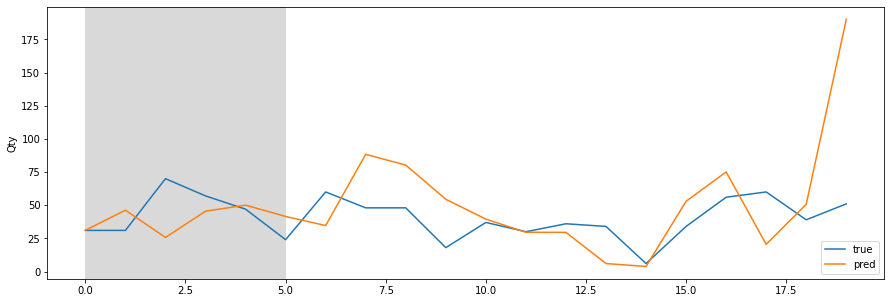

MSE: 38.66871177578946


In [67]:
# plot predictions test
plot_comparison(start_idx=0, length=20, train=False, model=model_LSTM)

In [68]:
# Create GRU model
model_GRU = Sequential()
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(None, 6)))
model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dense(units=1, activation='relu'))

In [69]:
%%time
# compile the model
model_GRU.compile(optimizer='adam', loss='mse')
history_GRU = model_GRU.fit(X_batch, y_batch, epochs=200, validation_data=validation_data, verbose=1, steps_per_epoch=200, callbacks=EarlyStopping(monitor='val_loss', patience=50, verbose=1))

Epoch 1/200
200/200 [==============================] - 4s 10ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 2/200
200/200 [==============================] - 1s 7ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 3/200
200/200 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0135
Epoch 4/200
200/200 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0127
Epoch 5/200
200/200 [==============================] - 1s 7ms/step - loss: 8.3593e-04 - val_loss: 0.0114
Epoch 6/200
200/200 [==============================] - 1s 6ms/step - loss: 6.1305e-04 - val_loss: 0.0117
Epoch 7/200
200/200 [==============================] - 1s 7ms/step - loss: 4.7587e-04 - val_loss: 0.0119
Epoch 8/200
200/200 [==============================] - 1s 6ms/step - loss: 4.2024e-04 - val_loss: 0.0123
Epoch 9/200
200/200 [==============================] - 1s 6ms/step - loss: 3.7517e-04 - val_loss: 0.0131
Epoch 10/200
200/200 [==============================] - 1s 7ms/step - 

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 50)          2850      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 50)          5050      
_________________________________________________________________
dense (Dense)                (None, None, 1)           51        
Total params: 7,951
Trainable params: 7,951
Non-trainable params: 0
_________________________________________________________________


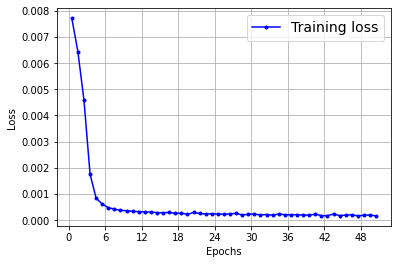

In [71]:
# plot learning curves
plot_learning_curves(history_GRU.history["loss"])
plt.show()

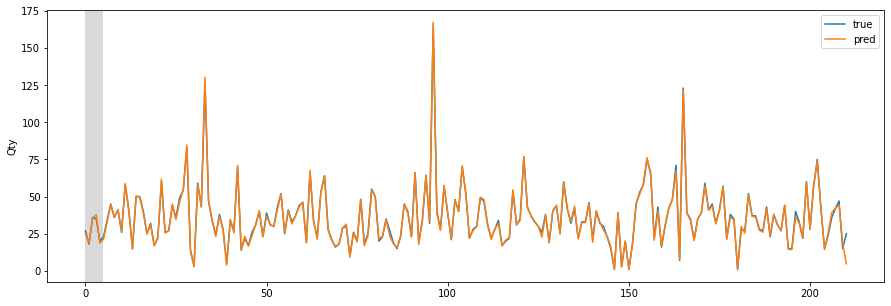

MSE: 1.7948076392503678


In [72]:
# plot predictions train
plot_comparison(start_idx=50, length=250, train=True, model=model_GRU)

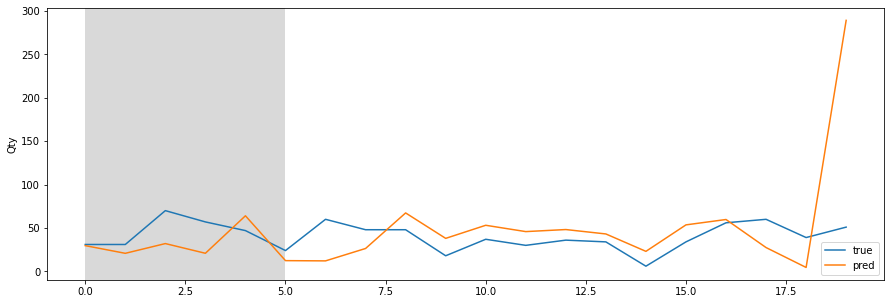

MSE: 57.978555330653286


In [73]:
# plot predictions test
plot_comparison(start_idx=0, length=20, train=False, model=model_GRU)

In [74]:
# Data preprocessing for 1D CNN
# Scale X
X_scaler_1D = MinMaxScaler()
X_scaled_1D = X_scaler_1D.fit_transform(X)

In [75]:
def batch_generator_1D(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, 6)
        batch_1D = np.zeros(shape=x_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X.shape[0] - sequence_length)
            
            # Copy the sequences of data starting at this index.
            batch_1D[i] = X_scaled_1D[idx:idx+sequence_length]
        
        yield (batch_1D)

In [76]:
batch_1D = next(batch_generator_1D(batch_size=300, sequence_length=120))

In [77]:
# Batch for 1D convolutional
X_train_1D = batch_1D[:210, :90]
X_valid_1D = batch_1D[210:270, :90]
X_test_1D = batch_1D[270:, :90]
Y_1D = np.empty((300,90,30))
for step_ahead in range (1, 30+1):
  Y_1D[..., step_ahead - 1] = batch_1D[..., step_ahead:step_ahead + 90, 0]
y_train_1D = Y_1D[:210]
y_valid_1D = Y_1D[210:270]
y_test_1D = Y_1D[270:]

In [78]:
X_train_1D.shape, y_train_1D.shape

((210, 90, 6), (210, 90, 30))

In [79]:
# create convolutional model
model_1D = Sequential()
model_1D.add(InputLayer(input_shape=[None, 6]))
for rate in (1, 2, 4, 8) * 2:
    model_1D.add(Conv1D(filters=60, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_1D.add(Conv1D(filters=30, kernel_size=1))

In [80]:
# compile the model
model_1D.compile(loss="mse", optimizer="adam")

In [81]:
model_1D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          780       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 60)          7260      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 60)          7260      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 60)          7260      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 60)          7260      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 60)          7260      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 60)         

In [82]:
%%time
# train the model
history_1D = model_1D.fit(X_train_1D, y_train_1D, epochs=500, validation_data=(X_valid_1D, y_valid_1D),callbacks=EarlyStopping(monitor='val_loss', patience=50, verbose=1))

Epoch 1/500
7/7 [==============================] - 14s 69ms/step - loss: 0.0231 - val_loss: 0.0183
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0134
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 6/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 10/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 11/500
7/7 [========

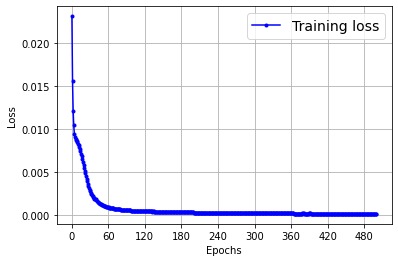

In [83]:
# plot learning curves
plot_learning_curves(history_1D.history["loss"])

In [84]:
# plot predictions function
def plot_comparison_1D(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = X_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # x = x.reshape((1, x.shape[0], x.shape[1]))

    # Use the model to predict the output-signals.
    y_pred = model_1D.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    
    # For each output-signal.
    for signal in range(len(target)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, 5, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target[signal])
        plt.legend()
        plt.show()
        # print sklearn mean squared error
        print('MSE:', np.sqrt(mean_squared_error(signal_true, signal_pred)))

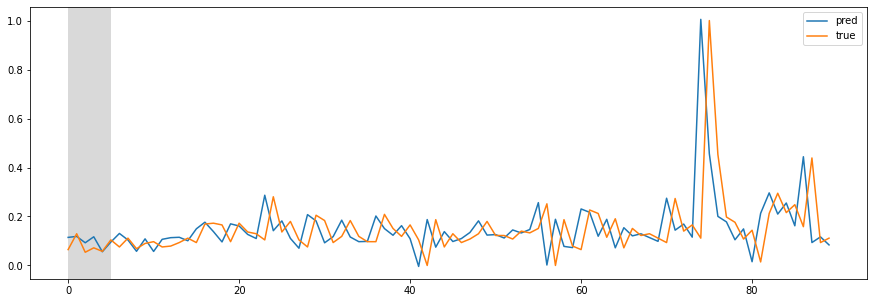

MSE: 14.543768763542175


In [85]:
y_pred = model_1D.predict(X_test_1D)
plt.figure(figsize=(15,5))
plt.plot(y_pred[5,:,0], label='pred')
plt.plot(X_test_1D[5,:,0], label = 'true')
p = plt.axvspan(0, 5, facecolor='black', alpha=0.15)
plt.legend()
plt.show()
print('MSE:', np.sqrt(mean_squared_error(X_test_1D[5,:,0], y_pred[5,:,0]))*100)

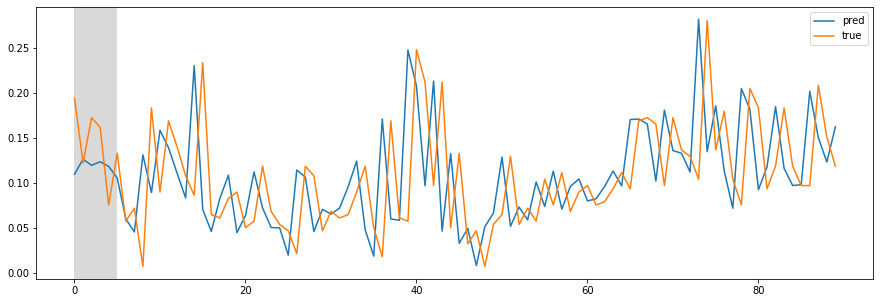

MSE: 6.861748546361923


In [86]:
y_pred = model_1D.predict(X_train_1D)
plt.figure(figsize=(15,5))
plt.plot(y_pred[5,:,0], label='pred')
plt.plot(X_train_1D[5,:,0], label = 'true')
p = plt.axvspan(0, 5, facecolor='black', alpha=0.15)
plt.legend()
plt.show()
print('MSE:', np.sqrt(mean_squared_error(X_train_1D[5,:,0], y_pred[5,:,0]))*100)